In [1]:
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
from torchmodel import UNet
from root_dataset import Root_dataset
import albumentations as albu
import segmentation_models_pytorch as smp

KeyboardInterrupt: 

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
def get_train_augmentation(height):
    trainaugmentation = albu.Compose([
        albu.Resize(height,height),
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.RandomRotate90(p=0.5),
        albu.Transpose(p=0.5),
        albu.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=15, p=0.5),
        albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        albu.GridDistortion(p=0.5),
        albu.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        albu.RandomBrightnessContrast(p=0.5),
        albu.RandomGamma(p=0.5),
        albu.GaussianBlur(blur_limit=(3, 7), p=0.5),
        albu.GaussNoise(),
        albu.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5), 
        #albu.Lambda(image=lambda x,**kwargs: x/255),
    ])
    return trainaugmentation

In [ ]:
def get_val_augmentation(height):
    trainaugmentation = albu.Compose([
        albu.Resize(height,height),
        # albu.Lambda(image=lambda x,**kwargs: x/255),
    ])
    return trainaugmentation

In [ ]:
train_aug = get_train_augmentation(512)
val_aug = get_val_augmentation(512)

In [ ]:
train = Root_dataset(train_aug,'crosval/train','castom-masks/masks_machine',device)
val = Root_dataset(val_aug,'crosval/val','castom-masks/masks_machine',device)

['AAE_0014.png', 'AAE_0016.png', 'AAE_0017.png', 'AAE_0019.png', 'AAE_0021.png', 'AAE_0022.png', 'AAE_0025.png', 'AAE_0027.png', 'AAE_0028.png', 'AAE_0036.png', 'AAE_0037.png', 'AAE_0040.png', 'AAE_0041.png', 'AAE_0045.png', 'AAE_0047.png', 'AAE_0048.png', 'AAE_0057.png', 'AAE_0058.png', 'AAE_0062.png', 'AAE_0063.png', 'AAE_0068.png', 'AAE_0070.png', 'AAE_0071.png', 'AAE_0073.png', 'AAE_0076.png', 'AAE_0080.png', 'AAE_0083.png', 'AAE_0085.png', 'AAE_0087.png', 'AAE_0089.png', 'AAE_0097.png', 'AAE_0098.png', 'AAE_0100.png', 'AAE_0101.png', 'AAE_0107.png', 'AAE_0114.png', 'AAE_0116.png', 'AAE_0117.png', 'AAE_0119.png', 'AAE_0124.png', 'AAE_0125.png', 'AAE_0127.png', 'AAE_0136.png', 'AAE_0140.png', 'AAE_0144.png', 'AAE_0145.png', 'AAE_0146.png', 'AAE_0147.png', 'AAE_0150.png', 'AAE_0154.png', 'AAE_0156.png', 'AAE_0158.png', 'AAE_0161.png', 'AAE_0165.png', 'AAE_0167.png', 'AAE_0170.png', 'AAE_0173.png', 'AAE_0174.png', 'AAE_0176.png', 'AAE_0177.png', 'AAE_0179.png', 'AAE_0180.png', 'AAE_01

<Figure size 640x480 with 0 Axes>

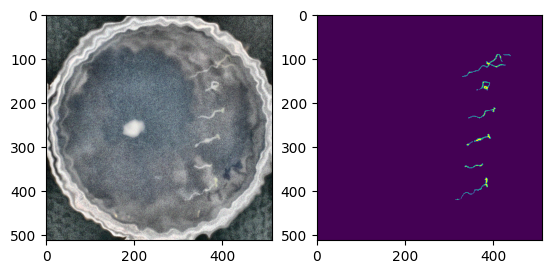

In [ ]:
plt.figure()
f, axarr = plt.subplots(1,2) 
image,mask = train.__getitem__(0)
axarr[0].imshow(image.permute(1,2,0).cpu())
axarr[1].imshow(mask.permute(1,2,0).cpu())

In [ ]:
model = UNet(3,1)

In [ ]:
train_loader = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val, batch_size=4, shuffle=False, num_workers=2)

In [ ]:
loss_f = smp.losses.FocalLoss('binary')
optimizer = torch.optim.Adam(model.parameters(),0.001,amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=2)

In [ ]:
epochs = 20

In [ ]:
model.to(device)
best_loss = 100
for epoch in range(epochs):
    train_loss = 0.0
    model.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_f(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader)
    val_loss = 0.0

    model.eval()
    for inputs, targets in tqdm(val_loader):
        model.eval()
        outputs = model(inputs)
            
            # Calculate loss
        loss = loss_f(outputs, targets)
        val_loss += loss.item()

    val_loss /= len(val_loader)

    scheduler.step(val_loss)

    if val_loss < best_loss: 
        best_loss = val_loss
        torch.save(model, 'best-model.pt')

    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 28/28 [00:06<00:00,  4.14it/s]


Epoch [1/20] | Train Loss: 0.3482 | Val Loss: 0.3450


100%|██████████| 28/28 [00:06<00:00,  4.24it/s]


Epoch [2/20] | Train Loss: 0.3008 | Val Loss: 0.3063


100%|██████████| 28/28 [00:06<00:00,  4.26it/s]


Epoch [3/20] | Train Loss: 0.2750 | Val Loss: 0.2926


100%|██████████| 28/28 [00:06<00:00,  4.23it/s]


Epoch [4/20] | Train Loss: 0.2573 | Val Loss: 0.2715


 38%|███▊      | 3/8 [14:06<23:31, 282.23s/it]


KeyboardInterrupt: 

In [ ]:
model = torch.load('best-model.pt')

Epoch [10/10] | Train Loss: 4.1113 | Val Loss: 3.9804

In [ ]:
outputs
for inputs, targets in tqdm(val_loader):
    model.eval()
    outputs = model(inputs)

100%|██████████| 31/31 [00:08<00:00,  3.85it/s]


In [ ]:
outputs.shape
outputs = outputs.reshape(1, 512, 512)

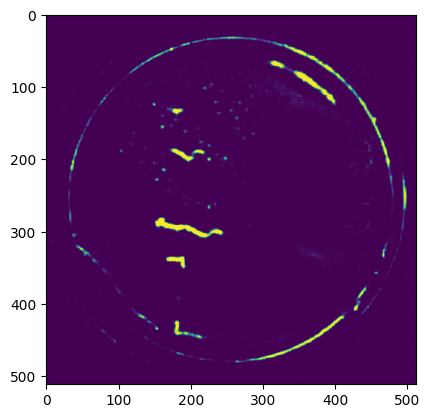

In [ ]:
plt.imshow(outputs.permute(1,2,0).detach().numpy())